## **5-2. LSTM 셀 구현**

### **라이브러리 호출**

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter # 파라미터 목록을 가지고 있는 라이브러리
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

### **데이터 준비**

**데이터 전처리**

In [3]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,)) # 데이터 정규화
])

**데이터셋 내려받기**

In [4]:
from torchvision.datasets import MNIST

download_root = 'MNIST_DATASET/'

train_dataset = MNIST(download_root, transform = mnist_transform, train = True, download = True)
valid_dataset = MNIST(download_root, transform = mnist_transform, train = False, download = True)
test_dataset = MNIST(download_root, transform = mnist_transform, train = False, download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_DATASET/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_DATASET/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_DATASET/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_DATASET/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_DATASET/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_DATASET/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST\raw



**데이터셋 메모리에 올리기**

In [5]:
batch_size = 64

train_loader = DataLoader(dataset = train_dataset, 
                         batch_size = batch_size,
                         shuffle = True)
valid_loader = DataLoader(dataset = test_dataset, 
                         batch_size = batch_size,
                         shuffle = True)
test_loader = DataLoader(dataset = test_dataset, 
                         batch_size = batch_size,
                         shuffle = True)

### **모델링**

**변수 값 지정**

In [6]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / ( len(train_dataset) / batch_size )
num_epochs = int(num_epochs)

**LSTM 셀 네트워크 구축**
- 게이트 위주의 cell 구현

In [7]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias) # 입력층
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias) # 은닉층
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std) # 난수 생성
    
    def forward(self, x, hidden):        
        hx, cx = hidden        
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
        # gates = F.linear(input, w_ih, b_ih) + F.linear(hx, w_hh, b_hh)와 동일
        gates = gates.squeeze() # tensor의 차원 축소(2차원 -> 1차원)        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1) # 텐서를 4개로 쪼갬
        
        ## 각각의 gate에 맞게 활성화 함수 처리
        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)
        
        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)        
        hy = torch.mul(outgate, F.tanh(cy))
        
        return (hy, cy)

**LSTM 셀의 전반적인 네트워크**

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias = True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim # 은닉층의 뉴런(유닛) 개수
         
        self.layer_dim = layer_dim               
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim) # 앞서 정의한 함수를 호출하여 cell 구현        
        self.fc = nn.Linear(hidden_dim, output_dim)
         
    def forward(self, x): 
        # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태를 0으로 초기화
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 셀 상태를 0으로 초기화
        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))
                           
        outs = []        
        cn = c0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 셀 상태에 대한 텐서
        hn = h0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태에 대한 텐서

        for seq in range(x.size(1)): # LSTM  셀 계층을 반복하여 쌓아 올림
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) # 은닉 상태(hn)와 셀 상태를 LSTMCell에 적용한 결과를 또다시 hn, cn에 저장
            outs.append(hn)
                
        out = outs[-1].squeeze()        
        out = self.fc(out) 
        
        return out

**옵티마이져, 손실 함수 지정**

In [9]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  
output_dim = 10
 
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

**학습 및 성능 확인**

In [10]:
seq_dim = 28 
loss_list = []
iter = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  # 훈련 데이터셋을 이용한 모델 학습        
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
          
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) # 손실 함수를 이용하여 오차 계산

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step() # 파라미터 업데이트      
        loss_list.append(loss.item())
        iter += 1
         
        if iter % 500 == 0: # 정확도 계산        
            correct = 0
            total = 0
            for images, labels in valid_loader: # 검증 데이터셋을 이용한 모델 성능 검증
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1) # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기
                 
                total += labels.size(0) # 총 레이블 수 
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

c:\users\doroc\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\users\doroc\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration: 500. Loss: 2.237457513809204. Accuracy: 21.420000076293945
Iteration: 1000. Loss: 0.8247257471084595. Accuracy: 76.13999938964844
Iteration: 1500. Loss: 0.4205913841724396. Accuracy: 89.0199966430664
Iteration: 2000. Loss: 0.25726011395454407. Accuracy: 93.01000213623047
Iteration: 2500. Loss: 0.06256351619958878. Accuracy: 95.5
Iteration: 3000. Loss: 0.0712197944521904. Accuracy: 96.27999877929688
Iteration: 3500. Loss: 0.1383725106716156. Accuracy: 96.58000183105469
Iteration: 4000. Loss: 0.04504479095339775. Accuracy: 96.54000091552734
Iteration: 4500. Loss: 0.05652716010808945. Accuracy: 97.16000366210938
Iteration: 5000. Loss: 0.06691935658454895. Accuracy: 97.33000183105469
Iteration: 5500. Loss: 0.12820550799369812. Accuracy: 97.3499984741211
Iteration: 6000. Loss: 0.013683550991117954. Accuracy: 97.80000305175781
Iteration: 6500. Loss: 0.031900353729724884. Accuracy: 97.4800033569336
Iteration: 7000. Loss: 0.016825499013066292. Accuracy: 98.0199966430664
Iteration: 7

- 정확도가 97% 정도로 굉장히 높은 것을 확인할 수 있음

### **예측**

In [11]:
def evaluate(model, val_iter):    
    corrects, total, total_loss = 0, 0, 0
    
    model.eval()
    
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)
             
        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

**예측 성능 확인**

In [12]:
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


## **5-3. LSTM 계층 구현**

### **라이브러리 호출**

In [13]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### **데이터 준비**
- 스타벅스 주가 데이터 활용

In [14]:
data = pd.read_csv('./data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


- `Date` 컬럼을 인덱스로 활용

In [15]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)

In [16]:
### 데이터형 변경
# 정수(int) -> 실수(float)

data['Volume'] = data['Volume'].astype(float)

**데이터 분리**

In [17]:
X = data.iloc[:,:-1] # 마지막 칼럼을 제외하고 모두 x로 사용
y = data.iloc[:,5:6] # 마지막 'volume'을 레이블로 활용
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

**데이터 분포 조정**
- 분산 조정

In [18]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y) 

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


**데이터셋 형태 및 크기 조정**
- 네트워크에 맞는 형태 및 크기로 변경

In [19]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


### **모델링**

**LSTM 네트워크**

In [20]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기(= 훈련 데이터셋의 칼럼 개수)
        self.hidden_size = hidden_size # 은닉층의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers = num_layers, batch_first = True) # LSTM 계층
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전 연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()
    
    def forward(self,x):
        ## 변수 초기화
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉층
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        
        hn = hn.view(-1, self.hidden_size) 
        
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        
        return out

**변수 설정**

In [21]:
num_epochs = 1000 
learning_rate = 0.0001 

input_size = 5 
hidden_size = 2 
num_layers = 1 
num_classes = 1 

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 
criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

**모델 학습**

In [22]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()  
    loss = criterion(outputs, y_train_tensors) # 손실 함수를 이용한 오차 계산
    loss.backward() # 기울기 계산
    optimizer.step() # 오차 업데이트
    
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.18287
Epoch: 100, loss: 0.05713
Epoch: 200, loss: 0.03855
Epoch: 300, loss: 0.03717
Epoch: 400, loss: 0.03599
Epoch: 500, loss: 0.03326
Epoch: 600, loss: 0.02937
Epoch: 700, loss: 0.02517
Epoch: 800, loss: 0.02214
Epoch: 900, loss: 0.02043


### **예측 결과 확인**
- 시각화를 하여 확인해보자.

In [23]:
df_x_ss = ss.transform(data.iloc[:, :-1]) # 데이터 정규화
df_y_ms = ms.transform(data.iloc[:, -1:]) # 데이터 정규화

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))

df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

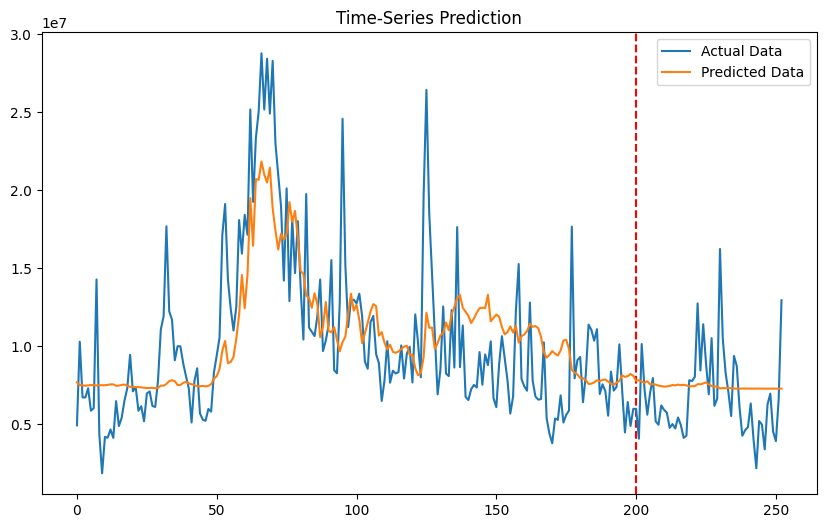

In [24]:
### 예측 결과 출력

train_predict = model(df_x_ss) # 모델 학습
predicted = train_predict.data.numpy() # 학습 결과를 numpy로 변경
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

- 어느 정도 예측이 비슷하지만 만족할 만한 정도는 아님